# Compatibility tests

This notebook contains the code used to check the compatibility between
CAN messages and CANflict techniques.

**Note:** In order to execute this test, you must:
1. unzip the `dataset.zip` file
2. copy the `canframe.py` script from the `CANHACK` repository

## UART

Function to check the existence of a UART polyglot that is compatible with the
given bitstream.

In [83]:
from typing import List

MIN_PAYLOAD = 5
MAX_PAYLOAD = 9

def uart_check_next(msg: str, startbit: int, curstack: List[int], debug: bool) -> bool:
    """
    Recursively search for a valid length for the next UART packet for a given
    CAN message, until the end of the packet is met or no solutions are
    available.

    Returns whether a valid solution was found or not.

    curstack is populated with the solution, if any, in the form of a list
    of the lengths of the payload of each UART packet to be sent.
    """        
    assert(startbit < len(msg))

    # If the remaining part of the message is all 1s, we can  avoid sending a
    # packet, since the default state of the bus is recessive
    allRecessive = True
    for idx in range(startbit,len(msg)):
        if msg[idx] == '0':
            allRecessive = False
            break
    
    if allRecessive:
        return True
    
    # If the first bit of the packet is not 0, we already have a problem
    if msg[startbit] != '0':
        return False
    
    # Check with any possible payload length
    for payload_len in range(MIN_PAYLOAD, MAX_PAYLOAD + 1):
        endbit = startbit + payload_len + 1

        # If the end bit is past the end of the message, the stop condition
        # is verified, since we can always append recessive bits at the end of
        # the message, as they are interpreted as silence on the CAN bus
        if endbit >= len(msg) - 1:
            if debug:
                curstack.append(payload_len)
            return True

        # If the end bit is a recessive bit, find the next packet
        elif msg[endbit] == '1':
            if debug:
                curstack.append(payload_len)

            # Recursive call for the next packet
            leads_to_valid_solution = uart_check_next(msg, endbit + 1, curstack, debug)

            if leads_to_valid_solution:
                return True
            else:
                # If no solution was found from here, this length cannot
                # be used
                if debug:
                    curstack.pop()
    
    # If none of the attempts in the loop led to a valid solution, we get here
    return False


Helpers to print the solution found

In [84]:
def print_sol(msg:str, solution: List[int]):
    print(msg)
    for idx in range(0, len(solution)):
        print("^",end='')
        for i in range(0,solution[idx]):
            print(i+1, end='')
        print("^", end='')



def uart_check(msg: str, debug: bool) -> bool:
    if debug:
        print("\nChecking " + msg)

    solution = []
    valid = uart_check_next(msg, 0, solution, debug)

    if debug:    
        if valid:
            print(solution)
            print_sol(msg,solution)
        else:
            print("no solution found")

    return valid


Simple tests

In [85]:
uart_check('000000000000000000000000000000000000', True)
uart_check('111111111111111111111111111111111111', True)
uart_check('010101010010101010101010101010101010', True)


Checking 000000000000000000000000000000000000
no solution found

Checking 111111111111111111111111111111111111
[]
111111111111111111111111111111111111

Checking 010101010010101010101010101010101010
[6, 5, 6, 6, 5]
010101010010101010101010101010101010
^123456^^12345^^123456^^123456^^12345^

True

Evaluation on a dataset

In [86]:
def evaluate_uart(frames, n_rows: int, n_bits: int) -> int:
    n_compatible = 0

    for frame in frames[0:n_rows]:
        valid = uart_check(frame[0:n_bits], False)
        if valid:
            n_compatible += 1

    return n_compatible

## I2C

Function to check the existence of a I2C polyglot that is compatible with the
given bitstream.

Note that here we are assuming the settings used in the paper, i.e.:
1. Start condition: 1 bit (value 0)
2. NACK: 1 bit (value 1)
3. Stop condition: 1 bit (value 0)
3. IFS: 2 bit (value 1)

Note that the IFS can be ignored in case of reading, since these bits
are not read by the I2C peripheral.

In [87]:
def i2c_check(msg: str, debug: bool, reading: bool) -> bool:
    if debug:
        print(msg)

    idx = 0
    while idx < len(msg):

        # If all the remaining bits are recessive, we don't need
        # to craft a packet
        all_recessive = True
        for i in range(idx, len(msg)):
            if msg[i] == '0':
                all_recessive = False
                
        if all_recessive:
            return True

        # If there's no space left for a packet, we're done
        if idx + 12 > len(msg):
            return True

        # Start condition
        if debug:
            print('^', end="")
        if msg[idx] != '0':
            return False
        idx += 1

        # Payload
        if debug:
            print('-'*8, end="")
        idx += 8
        
        # NACK
        if debug:
            print('*', end="")
        if msg[idx] != '1':
            return False
        idx += 1

        # Stop Bit
        if debug:
            print('X', end="")
        if msg[idx] != '0':
            return False
        idx += 1

        # If the packet is finished, we're done
        if idx + 1 >= len(msg):
            return True

        # IFS
        if debug:
            print('~~', end="")
        # When reading, we can ignore the IFS, since it is not read by the I2C
        if reading:
            if msg[idx] != '1' or msg[idx+1] != '1':
                return False

        idx += 2

Simple test on known bitstream

In [88]:
print(i2c_check('001110001101100000100010110001010111011111111111', True, True))
print(i2c_check('001110001101100000100010110001010111011111111111', True, False))

001110001101100000100010110001010111011111111111
^--------*X~~^--------*X~~^--------*X~~True
001110001101100000100010110001010111011111111111
^--------*X~~^--------*X~~^--------*X~~True


Evaluation on a dataset

In [89]:
def evaluate_i2c(frames, n_rows: int, n_bits: int, reading: bool) -> int:
    n_compatible = 0

    for frame in frames[0:n_rows]:
        valid = i2c_check(frame[0:n_bits], False, reading)
        if valid:
            n_compatible += 1

    return n_compatible

## ReCAN dataset

The following code runs the compatibility tests against all the messages of the
ReCAN dataset.

Before the tests can be run, we need to preprocess the dataset. In particular,
the dataset only tells us the id and payload of each message. We need to lower
that information to a bitstream that includes all the control fields, stuffing
bits and the CRC field.

To do this, we use Ken Tindell's `canframe` script, that can be found in the
[CANHACK](https://github.com/kentindell/canhack/) repository.

### 1. Import the Dataset

In [90]:
import pandas as pd

recan_dataset = pd.read_csv ('dataset.csv')
recan_dataset.head()

,time,line,id,len,data
0,1.573220e+09,can0,1A0,8,1111100100000000000000000000000000000000111111...
1,1.573220e+09,can0,1A2,8,0001001101101111000000000000000000000000000000...
2,1.573220e+09,can0,2B0,8,1111100101000010001110000001000000101001100010...
3,1.573220e+09,can0,4A6,8,0111111000111000000011111010000000000000000000...
4,1.573220e+09,can0,2B2,8,1111111111111111111111111111111111111111111111...


### 2. Convert data to bytes and id to int

The `data` field needs to be transformed into a list of bytes in order to be
fed to the `canframe` script.

In [91]:
def to_bytes(bitstream: str) -> bytes:
    return int(bitstream, 2).to_bytes(8, 'big')

recan_dataset['data_bytes'] = [to_bytes(x) for x in recan_dataset['data']]
recan_dataset['id_as_int'] = [int(x, 16) for x in recan_dataset['id']]
recan_dataset[['id', 'id_as_int', 'data', 'data_bytes']].head()

recan_dataset_reduced = recan_dataset[['id_as_int', 'data_bytes']]

### 3. Calculate the entire bitfield of each message

In [92]:
import sys
sys.path.append(".")

from canframe import CANFrame

def to_bitstream(the_id: int, data: bytes) -> str:
    frame = CANFrame(the_id, data, ack=1)
    return frame.bitseq()

frames = recan_dataset_reduced.apply(lambda row: to_bitstream(row['id_as_int'], row['data_bytes']), axis=1)
frames.head()

0    0001101000001000100011111000100000100000100000...
1    0001101000100001000001010011011011110000010000...
2    0010101100000100100011111000101000010001110000...
3    0100101001100001000011111010001110000010011111...
4    0010101100100001000111110111110111110111110111...
dtype: object

Save the coverted messages to a file

In [93]:
frames.to_csv("raw_bitfields.csv")

## Calculate compatibility for UART polyglots

Import the list of frames that have been converted as raw bitfields.

In [94]:
frames = pd.read_csv("raw_bitfields.csv")['0']
frames

0         0001101000001000100011111000100000100000100000...
1         0001101000100001000001010011011011110000010000...
2         0010101100000100100011111000101000010001110000...
3         0100101001100001000011111010001110000010011111...
4         0010101100100001000111110111110111110111110111...
                                ...                        
263264    0100101100000100100000100000100000100000100000...
263265    0001101100110001000110001110011000100000100000...
263266    0100011011110001000111110111110111110111110111...
263267    0100101001000001100000100000100011011000111100...
263268    0100101101100001000001111000001111000001000010...
Name: 0, Length: 263269, dtype: object

In [95]:
lengths = pd.Series([len(f) for f in frames])
lengths.describe()

count    263269.000000
mean        120.964998
std           2.874467
min         113.000000
25%         118.000000
50%         121.000000
75%         124.000000
max         126.000000
dtype: float64

Check the compatibility of each frame, considering the first N bits, with N
from 8 to the whole message.

The reason for this is that we assume that the attacker is typically
interested to only a part of the message, for example in the selective
DoS attack.

In [96]:
N_ROWS = len(frames)

datapoints = []

for n_bits in range(10, 130, 10):
    n_compatible_uart = evaluate_uart(frames, N_ROWS, n_bits)
    datapoints.append(n_compatible_uart)
    print("Done with %d" % n_bits)

datapoints_frac = [(x/N_ROWS) for x in datapoints]


Done with 10
Done with 20
Done with 30
Done with 40
Done with 50
Done with 60
Done with 70
Done with 80
Done with 90
Done with 100
Done with 110
Done with 120


Plot the compatibility for different lenghts

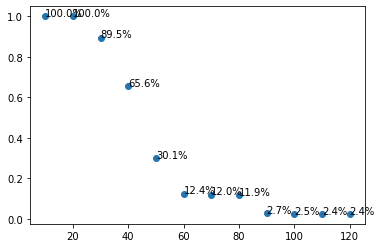

In [97]:
from matplotlib import pyplot as plt

y = datapoints_frac
z = range(10, 130, 10)
n = ["{:0.1f}%".format(x*100) for x in datapoints_frac]
datapoints_frac
fig, ax = plt.subplots()
ax.scatter(z, y)
ax.set_facecolor("white")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.savefig("uart.jpg", dpi=1200)


In [98]:
import plotly.express as px
df = px.data.tips()

frame = { 'Number of compatible packets': datapoints, 'Length of compatibility (bits)': range(10, 130, 10), 'Precentage': n }
result = pd.DataFrame(frame)

df = result

fig = px.line(df, y="Number of compatible packets", x="Length of compatibility (bits)", text="Precentage", markers=True)
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Number of compatible UART polyglots in the ReCAN dataset', title_x=0.5)
fig.show()
fig.write_image("uart.pdf")

## Calculate compatibility for I2C polyglots

Import the list of frames that have been converted as raw bitfields.

In [117]:
import pandas as pd

frames = pd.read_csv("raw_bitfields.csv")['0']
frames

0         0001101000001000100011111000100000100000100000...
1         0001101000100001000001010011011011110000010000...
2         0010101100000100100011111000101000010001110000...
3         0100101001100001000011111010001110000010011111...
4         0010101100100001000111110111110111110111110111...
                                ...                        
263264    0100101100000100100000100000100000100000100000...
263265    0001101100110001000110001110011000100000100000...
263266    0100011011110001000111110111110111110111110111...
263267    0100101001000001100000100000100011011000111100...
263268    0100101101100001000001111000001111000001000010...
Name: 0, Length: 263269, dtype: object

In [118]:
lengths = pd.Series([len(f) for f in frames])
lengths.describe()

count    263269.000000
mean        120.964998
std           2.874467
min         113.000000
25%         118.000000
50%         121.000000
75%         124.000000
max         126.000000
dtype: float64

## Reading

Check the compatibility of each frame, considering the first N bits, with N
from 12 to the whole message.

The reason for this is that we assume that the attacker is typically
interested to only a part of the message, for example in the selective
DoS attack.

In [119]:
N_ROWS = len(frames)

datapoints = []
bit_datapoints = range(12, 80, 12)

for n_bits in bit_datapoints:
    n_compatible = evaluate_i2c(frames, N_ROWS, n_bits, reading=True)
    datapoints.append(n_compatible)

    if n_bits % 10 == 0:
        print("Done with %d" % n_bits)

datapoints_frac = [(x/N_ROWS) for x in datapoints]


Done with 60


Plot the compatibility for different lenghts

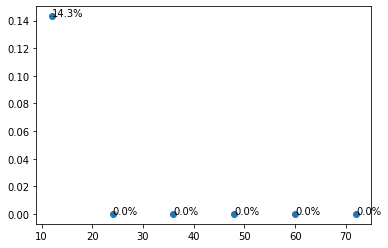

In [120]:
from matplotlib import pyplot as plt

y = datapoints_frac
z = bit_datapoints
n = ["{:0.1f}%".format(x*100) for x in datapoints_frac]
datapoints_frac
fig, ax = plt.subplots()
ax.scatter(z, y)
ax.set_facecolor("white")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [121]:
import plotly.express as px
df = px.data.tips()

frame = { 'Number of compatible packets': datapoints, 'Length of compatibility (bits)': bit_datapoints, 'Precentage': n }
result = pd.DataFrame(frame)

df = result

fig = px.line(df, y="Number of compatible packets", x="Length of compatibility (bits)", text="Precentage", markers=True)
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Number of compatible I2C polyglots in the ReCAN dataset (writing)', title_x=0.5)
fig.show()
fig.write_image("i2c_write.pdf")

## Writing

In [122]:
N_ROWS = len(frames)

datapoints = []
bit_datapoints = range(12, 80, 12)

for n_bits in bit_datapoints:
    n_compatible = evaluate_i2c(frames, N_ROWS, n_bits, reading=False)
    datapoints.append(n_compatible)

    if n_bits % 10 == 0:
        print("Done with %d" % n_bits)

datapoints_frac = [(x/N_ROWS) for x in datapoints]


Done with 60


Plot the compatibility for different lenghts

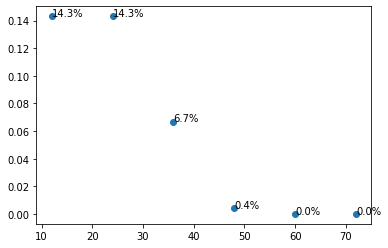

In [123]:
from matplotlib import pyplot as plt

y = datapoints_frac
z = bit_datapoints
n = ["{:0.1f}%".format(x*100) for x in datapoints_frac]
datapoints_frac
fig, ax = plt.subplots()
ax.scatter(z, y)
ax.set_facecolor("white")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [124]:
import plotly.express as px
df = px.data.tips()

frame = { 'Number of compatible packets': datapoints, 'Length of compatibility (bits)': bit_datapoints, 'Precentage': n }
result = pd.DataFrame(frame)

df = result

fig = px.line(df, y="Number of compatible packets", x="Length of compatibility (bits)", text="Precentage", markers=True)
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Number of compatible I2C polyglots in the ReCAN dataset (reading)', title_x=0.5)
fig.show()
fig.write_image("i2c_read.pdf")